In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import csv

/users/a/a/aametcal/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#get a list of all of the stations in the annual directory
os.chdir("/users/a/a/aametcal/scratch/isd-lite/annual90")
annualStationList = os.listdir()

In [4]:
annualStationList[:10]

['837860-99999.csv',
 '289410-99999.csv',
 '685750-99999.csv',
 '119273-99999.csv',
 '420560-99999.csv',
 '713030-99999.csv',
 '539130-99999.csv',
 '105640-99999.csv',
 '407200-99999.csv',
 '720413-99999.csv']

In [5]:
#get a list of all of the id's that we previously selected
#when preprocessing data
os.chdir("/users/a/a/aametcal/isd-lite/data_light/")
df = pd.read_csv('IDs_27813.csv',header = None)
statList = df[0].tolist()

In [6]:
#compare lists
statList[0], annualStationList[0][0:-4]

('008268-99999', '837860-99999')

In [7]:
#take off the .csv from the annualStationList
for i in range(len(annualStationList)):
    annualStationList[i] = annualStationList[i][0:-4]

In [8]:
#check lengthts 
len(statList[0]), len(annualStationList[0])

(12, 12)

In [9]:
#check
for stat in annualStationList:
    if len(stat)!= 12:
        print ('oh, no!')

In [10]:
#check
for stat in statList:
    if len(stat)!=12:
        print("oh, no!")

In [11]:
#turn into sets so we can perform intersect
statSet = set(statList)
annualStationSet = set(annualStationList)

In [12]:
#double check lengths
len(statSet), len(statList), len(annualStationList), len(annualStationSet)

(27813, 27813, 24066, 24066)

In [13]:
#perform intersect to get stations for analysis
stationSet = statSet.intersection(annualStationSet)

In [14]:
len(stationSet)

22405

In [15]:
stationList = list(stationSet)

In [16]:
#add back the .csv
for i in range(len(stationList)):
    stationList[i] = stationList[i]+".csv"

In [17]:
stationList[:5]

['544290-99999.csv',
 '789050-99999.csv',
 '122100-99999.csv',
 '388990-99999.csv',
 '960010-99999.csv']

## Now we need to check all of the stations in stationList to see if they have 46 records (1972 - 2017)

In [18]:
os.chdir("/users/a/a/aametcal/scratch/isd-lite/annual90")

In [19]:
statDict ={"stationNumber":[],
          "slope":[],
          "lowBound":[],
          "highBound":[],
          "slopeInt":[],
          "pw1972":[],
          "pw2017":[]}

In [20]:
statDict

{'highBound': [],
 'lowBound': [],
 'pw1972': [],
 'pw2017': [],
 'slope': [],
 'slopeInt': [],
 'stationNumber': []}

In [21]:
count = 0
for station in stationList:
        sdf = pd.read_csv(station)
        if len(sdf) !=(2017-1990+1):
            continue
        else:
            count+=1

In [22]:
print(count)

4812


In [23]:
start = 1972
end = 2017
span = end-start+1 
span

46

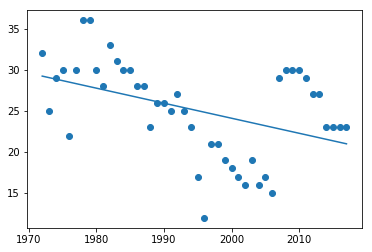

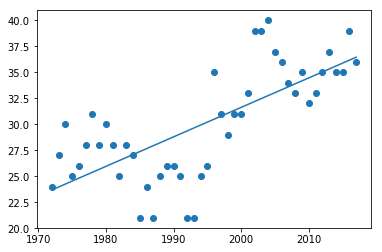

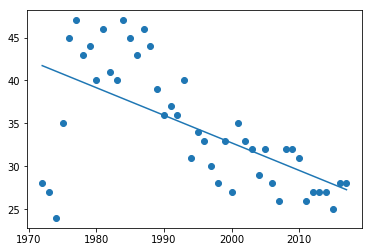

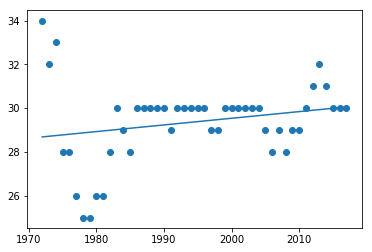

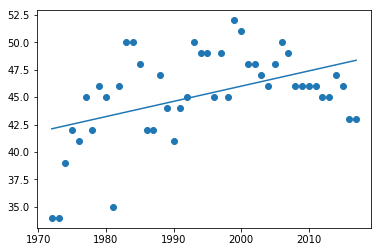

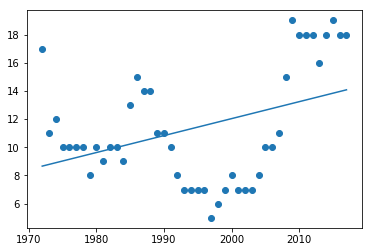

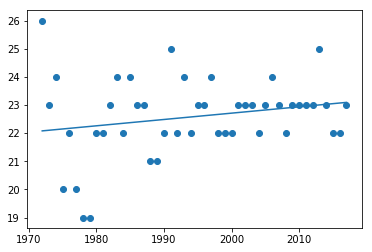

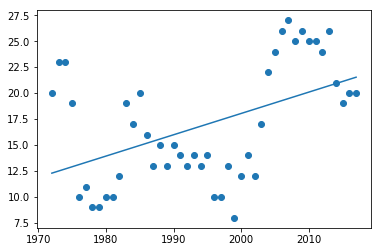

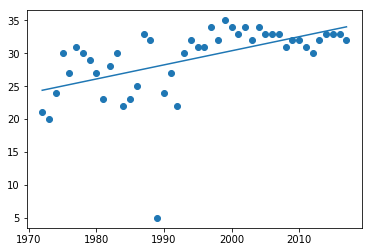

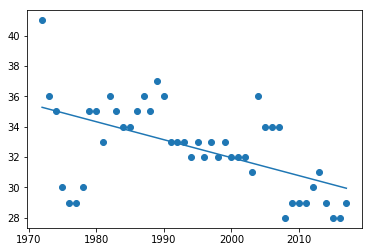

KeyboardInterrupt: 

In [25]:
with open("/users/a/a/aametcal/isd-lite/data_light/stationAttr", mode = 'w') as csv_file:
    fieldnames = ["stationNumber",
                  "slope",
                  "lowBound",
                  "hightBound",
                  "slopeInt",
                  "pw1972",
                  "pw2017"]
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    for station in stationList:
        sdf = pd.read_csv(station)
        if len(sdf) !=46:
            continue
        else:
            X = sdf.year
            #add a column of ones for intercept
            X_ = sm.add_constant(X)
            y = sdf.meanWindSpeed

            model = sm.OLS(y,X_).fit()
            #get the 95% confidence interval
            ci = model.conf_int(alpha=0.05)

            #calculate values for dictionary
            slope = model.params[1]
            lowBound = ci[0][1]
            highBound = ci[1][1]
            stationNumber = station[0:-4]
            pw1972 = sdf.prevailingWind.values[0]
            pw2017 = sdf.prevailingWind.values[-1] 

            if (lowBound<0 and highBound<0):
                slopeInt = -1
            elif (lowBound>0 and highBound>0):
                slopeInt = 1
            else:
                slopeInt = 0
            
            writer.writerow({"stationNumber":stationNumber,
                  "slope":slope,
                  "lowBound":lowBound,
                  "hightBound":highBound,
                  "slopeInt":slopeInt,
                  "pw1972":pw1972,
                  "pw2017":pw2017})

            predictions = model.predict(X_)
            plt.scatter(X,y)
            plt.plot(X,predictions)
            plt.show()
            

In [105]:
slope,slopeLow,slopeHigh

(-0.22565525747764317, -0.29473369353107337, -0.15657682142421298)

In [97]:
type(sdf.prevailingWind)

pandas.core.series.Series

In [99]:
sdf.prevailingWind.values[-1]

354

In [100]:
sdf.prevailingWind.values

array([ 18,  21,   0, 345,  14, 353, 121,  72, 100,  56, 356,  14,  20,
        57, 310,  42, 340,  95,  14,  42,  64,  40, 340,  22,  22,  37,
        25, 346, 346,   6,  29, 343,   7,  13, 322,  18,  14,  26,  25,
       359,  13,  22,   0,  23, 347, 354])

In [78]:
stationNum = station[0:-4]
stationNum

'724640-93058'

In [53]:
ci = model.conf_int()


In [20]:
x = sdf.year
y = sdf.meanWindSpeed
med = stats.theilslopes(y,x,0.95)


In [21]:
res


(-0.08888888888888889, 228.2888888888889, -0.18181818181818182, 0.0)

In [64]:
slope = model.params[1]

In [57]:
ci

,0,1
const,351.137244,626.697230
year,-0.294734,-0.156577


In [65]:
slopeLow = ci[0][1]
slopeHigh = ci[1][1]

In [67]:
slopeLow, slopeHigh

(-0.29473369353107337, -0.15657682142421298)

In [41]:
X = sdf.year
X_ = sm.add_constant(X)
y = sdf.meanWindSpeed

model = sm.OLS(y,X_).fit()
predictions = model.predict(X)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meanWindSpeed   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     43.34
Date:                Thu, 21 Feb 2019   Prob (F-statistic):           4.67e-08
Time:                        18:15:54   Log-Likelihood:                -116.09
No. Observations:                  46   AIC:                             236.2
Df Residuals:                      44   BIC:                             239.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        488.9172     68.365      7.152      0.000     351.137     626.697
year          -0.2257      0.034     -6.584      0.000      -0.295      -0.157
==============================================================================
Omnibus:                        3.819   Durbin-Watson:                   0.627
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.924
Skew:                          -0.605   Prob(JB):                        0.232
Kurtosis:                       3.246   Cond. No.                     3.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
model.params

const    488.917237
year      -0.225655
dtype: float64

In [43]:
model.conf_int()


,0,1
const,351.137244,626.697230
year,-0.294734,-0.156577


In [183]:
X = sdf[["year"]]

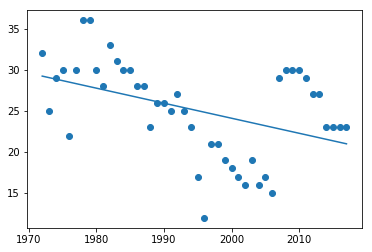

In [184]:
plt.scatter(X,y)

yFit = m*X+b
plt.plot(X,yFit)
plt.show()